José Delgado

In [102]:
import dill
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [60]:
df = pd.read_csv('data/training.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop('Machine Failure', axis=1), df['Machine Failure'], test_size=0.3, random_state=1234)

In [61]:
fit_models = {}
models = ['rf', 'gb', 'ridge', 'sgd']

In [62]:
model_files = [f"models/{model}_gridsearch.pkl" for model in models]

In [63]:
model_files

['models/rf_gridsearch.pkl',
 'models/gb_gridsearch.pkl',
 'models/ridge_gridsearch.pkl',
 'models/sgd_gridsearch.pkl']

In [64]:
for model_file in model_files:
    if os.path.exists(model_file):
        with open(model_file, 'rb') as f:
            model_name = os.path.basename(model_file).replace('_gridsearch.pkl', '')
            fit_models[model_name] = dill.load(f)

In [65]:
fit_models

{'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('pca', PCA(n_components=45)),
                                        ('randomforestclassifier',
                                         RandomForestClassifier(random_state=1234))]),
              n_jobs=-1,
              param_grid={'randomforestclassifier__max_depth': [None, 5, 7, 9],
                          'randomforestclassifier__n_estimators': [50, 100, 200,
                                                                   300, 400]}),
 'gb': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('pca', PCA(n_components=45)),
                                        ('gradientboostingclassifier',
                                         GradientBoostingClassifier(random_state=1234))]),
              n_jobs=-1,
              param_grid={'gradientboosti

# 7. Evaluate

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

## Calculate Classification Metrics

In [67]:
results = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1 Score", "Accuracy", "Confusion Matrix"])

In [68]:
for algo, model in fit_models.items():
    y_pred = model.predict(X_test)

    y_test_bin = y_test.map(lambda x: 1 if x == 'Failure' else 0)
    y_pred_bin = pd.Series(y_pred).map(lambda x: 1 if x == 'Failure' else 0)

    precision = precision_score(y_test_bin, y_pred_bin)
    recall = recall_score(y_test_bin, y_pred_bin)
    f1 = f1_score(y_test_bin, y_pred_bin)
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    conf_matrix = confusion_matrix(y_test_bin, y_pred_bin)

    model_results = pd.DataFrame({
        "Model": [algo],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "Accuracy": [accuracy],
        "Confusion Matrix": [conf_matrix]
    })

    results = pd.concat([results, model_results], ignore_index=True)

/var/folders/wm/vj5glycn0jnf5bn5_ympd8dc0000gn/T/ipykernel_25245/3527173090.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, model_results], ignore_index=True)


In [69]:
results

,Model,Precision,Recall,F1 Score,Accuracy,Confusion Matrix
0,rf,0.934426,0.811388,0.868571,0.964778,"[[1662, 16], [53, 228]]"
1,gb,0.945946,0.871886,0.907407,0.974477,"[[1664, 14], [36, 245]]"
2,ridge,1.000000,0.316726,0.481081,0.901991,"[[1678, 0], [192, 89]]"
3,sgd,1.000000,0.911032,0.953445,0.987238,"[[1678, 0], [25, 256]]"


## Review Confusion Matrix

In [70]:
model = fit_models['sgd']

In [71]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 256,   25],
       [   0, 1678]])

<Axes: >

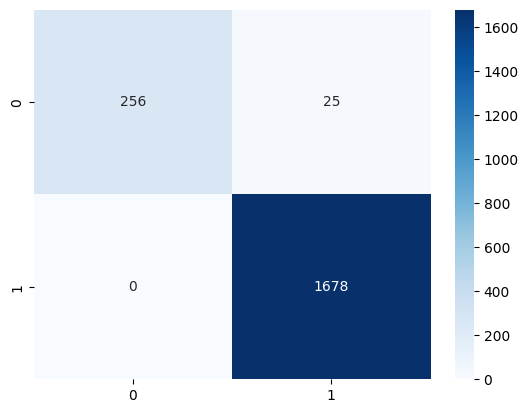

In [76]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [77]:
model.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=45)),
                ('sgdclassifier', SGDClassifier(random_state=1234))])

# 8. Deploy

## Call New Data to Be Scored

In [78]:
scoring = pd.read_csv('data/scoring.csv')

## Make Predictions

In [83]:
scoring_pred = model.predict(scoring)

In [84]:
scoring["Predictions"] = scoring_pred

In [86]:
scoring[scoring["Predictions"] == 'Failure']

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Predictions
6,-0.078387,2.110458,0.130328,0.725025,3.172707,7.250250,1.560629,0.082053,0.043510,-14.519905,...,2.406553,-2.521151,-0.165369,3.437933,-0.802184,0.751085,9.883227,78.753949,14.170723,Failure
24,-0.256254,2.119283,0.671730,0.663645,1.584472,6.636452,0.175151,0.304721,1.572918,-3.853938,...,3.546111,-3.714973,1.948698,5.065872,-1.182037,1.653248,27.423542,150.307337,14.194555,Failure
28,0.897561,2.505827,-0.203300,1.127276,-0.409926,11.272764,0.107353,0.077619,0.384833,25.825179,...,3.751139,-3.929764,1.010349,5.358770,-1.250380,2.178797,39.444315,96.050098,14.446836,Failure
32,1.963220,-0.499877,1.121868,1.125154,2.286975,11.251539,0.294067,0.908792,1.648004,6.219810,...,0.468033,-0.490320,2.134201,0.668618,-0.156011,-0.735163,18.647904,161.108554,14.145058,Failure
43,1.836739,1.458990,1.096666,0.346044,0.423312,3.460439,1.739671,-0.505383,-0.503702,30.932965,...,2.215962,-2.321484,0.727127,3.165660,-0.738654,-0.625000,4.323798,120.441302,14.234474,Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,1.807600,1.663417,-0.409371,1.964578,0.454398,19.645778,0.239588,1.511025,1.926141,25.846675,...,0.062708,-0.065694,2.149575,0.089582,-0.020903,0.209364,-3.920875,116.934204,14.246556,Failure
2136,1.442653,1.064387,1.790435,-2.006418,0.362424,-20.064180,2.742726,0.531228,-0.057920,5.622461,...,-0.488309,0.511562,-0.343440,-0.697584,0.162770,3.605998,30.417814,101.690546,14.247132,Failure
2140,1.032776,1.351728,-0.235847,1.060129,1.620374,10.601290,-0.361086,-1.003399,1.572735,30.135028,...,3.441591,-3.605476,-0.404022,4.916558,-1.147197,1.955478,-3.487685,122.925221,14.166708,Failure
2142,1.057368,1.920207,1.021273,-0.181090,2.074347,-1.810898,2.689663,-0.018764,0.023114,39.183065,...,3.380125,-3.541083,0.964521,4.828750,-1.126708,0.122994,11.096744,93.265483,14.491024,Failure


## Check if Predictions Table Exists, If Not Create It

In [87]:
import sqlite3

In [88]:
DB_PATH = os.path.join('data', 'iot.db')
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

In [89]:
PREDICTIONS_TABLE = '''
    SELECT
        name
    FROM
        sqlite_master
    WHERE
        type='table'
        AND 
        name='predictions';
'''

In [96]:
res = cur.execute(PREDICTIONS_TABLE)
tables = res.fetchall()

In [97]:
tables

[('predictions',)]

In [95]:
cur.execute(f"CREATE TABLE predictions {tuple(scoring.columns)};")

## Push back into Database

In [99]:
scoring.to_sql('predictions', conn, if_exists='replace', index=False)

2153

## View Loaded Results

In [100]:
res = cur.execute('SELECT * FROM predictions;')
predictions = res.fetchall()

In [103]:
sql_columns = np.array(cur.description)[:,0]
sql_predictions = pd.DataFrame(predictions, columns=sql_columns)

In [104]:
sql_predictions

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Predictions
0,0.585750,0.710870,0.961795,0.535207,1.327430,5.352066,2.226076,-1.417258,-0.713738,8.562829,...,2.128090,-2.229427,1.848735,3.040128,-0.709363,2.262458,4.951563,52.587106,14.281632,Running
1,1.394299,0.528989,0.403531,0.562596,1.060444,5.625960,1.060982,1.135943,1.141834,28.130973,...,1.086879,-1.138635,1.508479,1.552685,-0.362293,-0.873339,16.082543,24.111206,14.334397,Running
2,2.269294,0.324147,-0.033710,2.277046,-0.041533,22.770459,2.366656,-13.778314,-1.534053,13.036520,...,1.812740,-1.899061,1.184088,2.589629,-0.604247,0.854719,9.455773,70.558905,14.330505,Running
3,1.246255,1.932317,2.315582,0.766818,1.328568,7.668182,3.359558,4.186759,0.975112,-0.464028,...,0.837624,-0.877511,-0.106852,1.196606,-0.279208,-0.881114,23.510027,84.022643,14.339029,Running
4,0.325781,1.895224,0.821280,2.313757,0.544863,23.137572,0.278491,0.412551,0.384150,14.307797,...,4.628036,-4.848419,-0.632701,6.611480,-1.542679,4.790277,18.829649,75.828002,14.474880,Running
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,0.881909,2.160381,0.198874,0.528587,2.929006,5.285871,-0.149039,-0.044315,0.337509,41.450987,...,-2.480172,2.598276,0.516649,-3.543104,0.826724,1.201014,5.306023,107.888916,14.172600,Failure
2149,2.057214,0.904536,0.028225,1.553294,-0.967447,15.532938,1.853190,2.077073,0.432942,-22.393528,...,1.299062,-1.360922,0.393036,1.855803,-0.433021,2.579969,-6.533873,67.844550,14.265565,Running
2150,2.600971,-1.336006,2.951594,2.547870,2.756117,25.478697,0.066346,-0.150740,-0.535041,42.708971,...,2.833823,-2.968767,-0.021540,4.048319,-0.944608,0.795499,0.932315,-9.059734,14.311708,Running
2151,1.170571,0.347656,1.484250,0.527953,0.595716,5.279533,1.597344,2.290511,1.629632,31.414412,...,2.042757,-2.140031,0.659276,2.918224,-0.680919,1.265063,21.229727,-2.977392,14.192465,Running
